In [1]:
library(tidyverse,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)
library(data.table,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)
library(showtext,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)
library(rgdal,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)
library(lmtest,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)
library(gstat,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)
library(spdep,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)
library(RColorBrewer,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)
library(classInt,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)
library(spatialreg,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)
library(car,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)
library(leaflet,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE)
font_add_google('Nanum Pen Script', 'nanumpen')
showtext_auto()

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

rgdal: version: 1.5-16, (SVN revision 1050)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.1.2, released 2020/07/07
Path to GDAL shared files: /usr/local/gdal-3.1.2/share/gdal
GDAL binary built with GEOS: FALSE 
Loaded PROJ runtime: Rel. 6.1.0, May 15th, 2019, [PJ_VERSION: 610]
Path to PROJ shared files: /usr/local/proj-6.1.0/share/proj
Linking to sp version:1.4-2
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading rgdal.


Attaching package: ‘zoo’


The following object

# 1. 데이터 불러오기

In [41]:
data <- fread("data_f.csv",
             header = T,
             stringsAsFactors = F,
             data.table = F,
             encoding = "UTF-8",
             drop = "Y_youth_count")

data$cluster <- as.factor(data$cluster) 

In [3]:
data_16 <- readOGR(dsn = "16.용인시_소상공인_매출정보.geojson")
my_shp <- data_16[which(data_16$gid %in% data$gid), ] 

OGR data source with driver: GeoJSON 
Source: "/opt/app-root/src/테스트용/16.용인시_소상공인_매출정보.geojson", layer: "용인시_사업장정보"
with 9915 features
It has 66 fields


### 1.1공간 가중치 행렬(Weight Matrix) 계산 및 검정

In [42]:
my_nb <- poly2nb(my_shp, queen = FALSE)
my_listw <- nb2listw(my_nb, style = "W", zero.policy = TRUE)

#### 공간자기상관성 검정(Moran's I)
- 귀무가설(H0) : 공간 자기상관성이 없다

In [43]:
moran.test(data$Y_stable, my_listw , zero.policy = TRUE)


	Moran I test under randomisation

data:  data$Y_stable  
weights: my_listw  n reduced by no-neighbour observations
  

Moran I statistic standard deviate = 6.6711, p-value = 1.269e-11
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.242176258      -0.001396648       0.001333095 


- p-value가 0.05보다 작으므로 "공간 자기상관성이 없다"라는 귀무가설을 기각한다. 즉 공간 자기상관성을 고려해야한다

### 1.2. Local Moran's I - 핫스팟 시각화

In [44]:
local <- localmoran(x = data$Y_stable,listw = my_listw, zero.policy = TRUE)

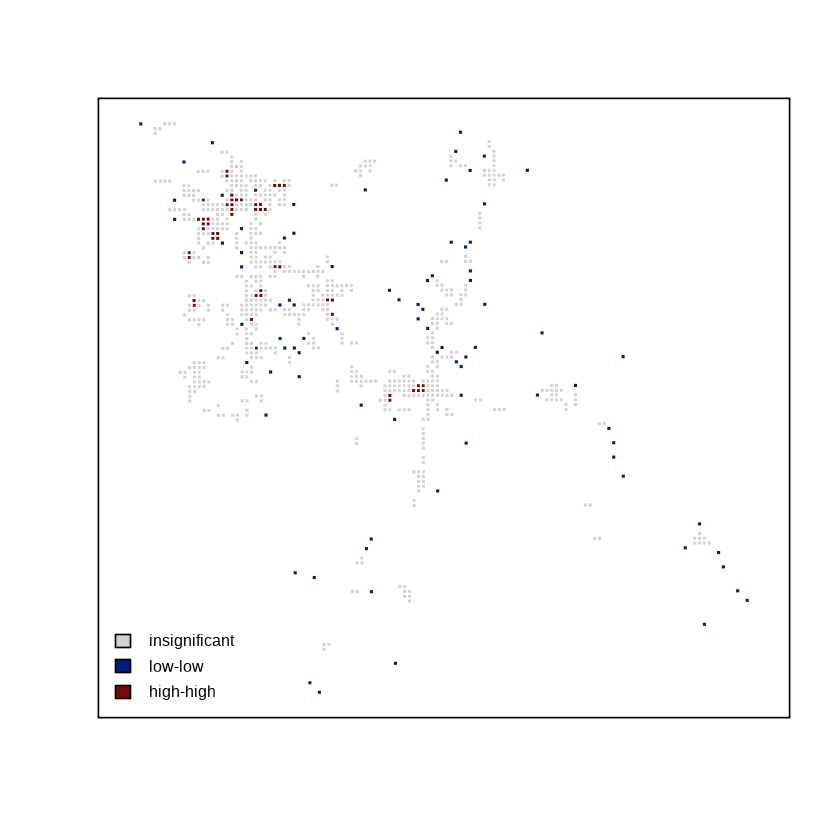

In [45]:
quadrant <- vector(mode="numeric",length=nrow(local))
m.qualification <-data$Y_stable - mean(data$Y_stable)
m.local <- local[,1] - mean(local[,1])
signif <- 0.1
quadrant[m.qualification >0 & m.local>0] <- 4
quadrant[m.qualification <0 & m.local<0] <- 1
#quadrant[m.qualification <0 & m.local>0] <- 2
#quadrant[m.qualification >0 & m.local<0] <- 3
quadrant[local[,5]>signif] <- 0

# plot in r
brks <- c(0,1,4)
colors <- c("lightgrey","#011d82","#750a08")
plot(my_shp, border="white",col=colors[findInterval(quadrant,brks,all.inside=FALSE)])
box()
legend("bottomleft",legend=c("insignificant","low-low","high-high"),
fill=colors,bty="n")


- 중부, 수지, 기흥쪽에 매출 핫스팟 지역 군집, 도로변 지역에 매출 콜드스팟 지역 있다고 해석 가능

# 2. 모델링

### 2.1 일반 회귀(OLS) 적합

In [49]:
scale_fun <- function(X) as.vector(scale(X))

data2 <- data %>% select(-gid)
data_scaled <- data2 %>% mutate_if(is.numeric, scale_fun)
data_scaled$Y_stable <- data$Y_stable

In [50]:
lm.fit <- lm(log(Y_stable)~., data =data_scaled) 

In [51]:
summary(lm.fit)


Call:
lm(formula = log(Y_stable) ~ ., data = data_scaled)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4671 -0.5421  0.0580  0.5622  3.1490 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)              8.35587    0.07030 118.852  < 2e-16 ***
smbiz_ratio             -0.48513    0.03493 -13.889  < 2e-16 ***
found_mid               -0.06116    0.03367  -1.817 0.069639 .  
age_2030                 0.08967    0.04923   1.821 0.068926 .  
age_4050                 0.15635    0.04202   3.721 0.000213 ***
age_6070                 0.13106    0.04075   3.216 0.001352 ** 
loan_excess              0.10458    0.03266   3.202 0.001420 ** 
sales_rate               0.09261    0.03182   2.911 0.003709 ** 
gid_variety              0.82049    0.04020  20.409  < 2e-16 ***
ROA_CLS_SE_1             0.01636    0.03225   0.507 0.612145    
ROA_CLS_SE_2             0.05597    0.03407   1.643 0.100819    
ROA_CLS_SE_3             0.05571    0.03369   1.654 

### 2.2. 공간시차모형/공간오차모형 선택
- LMerr : 공간 오차 모형
- LMlag : 공간 시차 모형
- P-value가 0.05 이하면 유의함. 만약 둘 다 유의할 경우 더 낮은 P-value로 모델 선택

In [52]:
lm.LMtests(lm.fit, my_listw, test="all", spChk=NULL, naSubset=TRUE, zero.policy = TRUE) 


	Lagrange multiplier diagnostics for spatial dependence

data:  
model: lm(formula = log(Y_stable) ~ ., data = data_scaled)
weights: my_listw

LMerr = 2.8592, df = 1, p-value = 0.09086


	Lagrange multiplier diagnostics for spatial dependence

data:  
model: lm(formula = log(Y_stable) ~ ., data = data_scaled)
weights: my_listw

LMlag = 16.781, df = 1, p-value = 4.194e-05


	Lagrange multiplier diagnostics for spatial dependence

data:  
model: lm(formula = log(Y_stable) ~ ., data = data_scaled)
weights: my_listw

RLMerr = 0.17818, df = 1, p-value = 0.6729


	Lagrange multiplier diagnostics for spatial dependence

data:  
model: lm(formula = log(Y_stable) ~ ., data = data_scaled)
weights: my_listw

RLMlag = 14.1, df = 1, p-value = 0.0001733


	Lagrange multiplier diagnostics for spatial dependence

data:  
model: lm(formula = log(Y_stable) ~ ., data = data_scaled)
weights: my_listw

SARMA = 16.96, df = 2, p-value = 0.0002076


- 공간 시차 모형이 유의하고 P-value가 가장 낮으므로 공간 시차 모형 사용

### 2.3 공간 시차 모형 적합

In [53]:
lm.fit_slx = lmSLX(log(Y_stable)~ ., data =data_scaled ,listw=my_listw, zero.policy = TRUE)

In [54]:
summary(lm.fit_slx)


Call:
lm(formula = formula(paste("y ~ ", paste(colnames(x)[-1], collapse = "+"))), 
    data = as.data.frame(x), weights = weights)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.5632 -0.5014  0.0576  0.5371  3.0242 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  8.284083   0.087043  95.172  < 2e-16 ***
smbiz_ratio                 -0.481933   0.034695 -13.890  < 2e-16 ***
found_mid                   -0.048238   0.033574  -1.437  0.15119    
age_2030                     0.021922   0.053388   0.411  0.68148    
age_4050                     0.142922   0.045921   3.112  0.00192 ** 
age_6070                     0.101401   0.042017   2.413  0.01604 *  
loan_excess                  0.092688   0.032578   2.845  0.00456 ** 
sales_rate                   0.085410   0.031327   2.726  0.00655 ** 
gid_variety                  0.775120   0.041230  18.800  < 2e-16 ***
ROA_CLS_SE_1                -0.008837   0.033373  -0.265  

In [55]:
print(paste0("일반회귀모형 Adjisted R2 : " ,round(summary(lm.fit)$adj.r.squared,4)))
print(paste0("공간시차모형 Adjisted R2 : " ,round(summary(lm.fit_slx)$adj.r.squared,4)))

[1] "일반회귀모형 Adjisted R2 : 0.5766"
[1] "공간시차모형 Adjisted R2 : 0.5942"


- 공간 시차 모형이 일반 회귀 모형에 비해 Adjusted R2 값이 더 좋아짐
- 공간 시차모형이 좀더 유의함

#### 2.3-1 공간시차모형 Plot

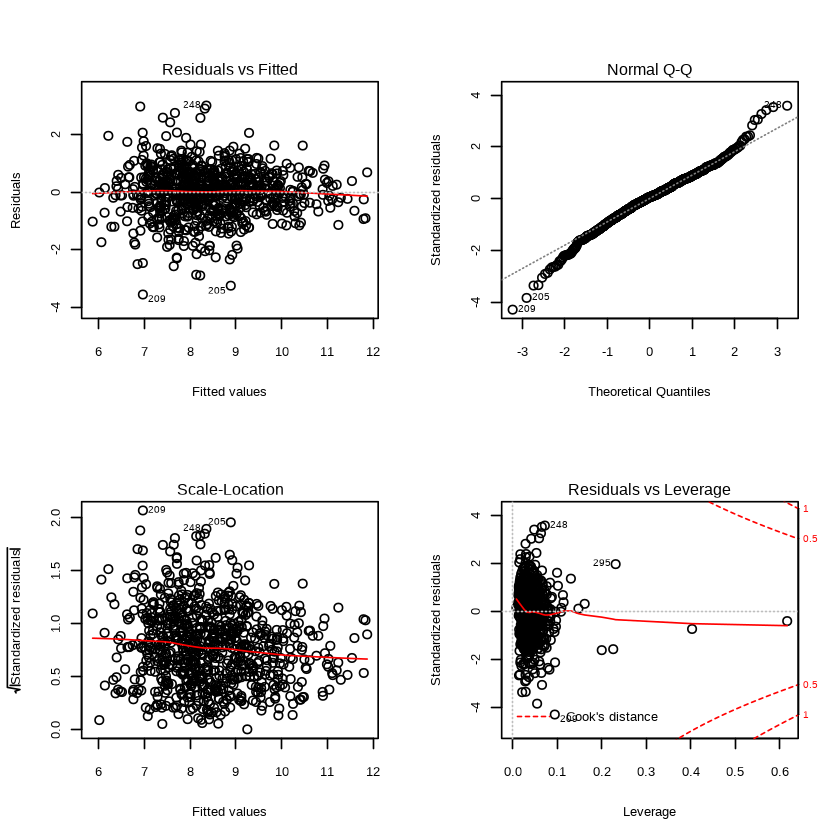

In [57]:
par(mfrow = c(2,2))
plot(lm.fit_slx)

#### 2.3-2 계수 시각화

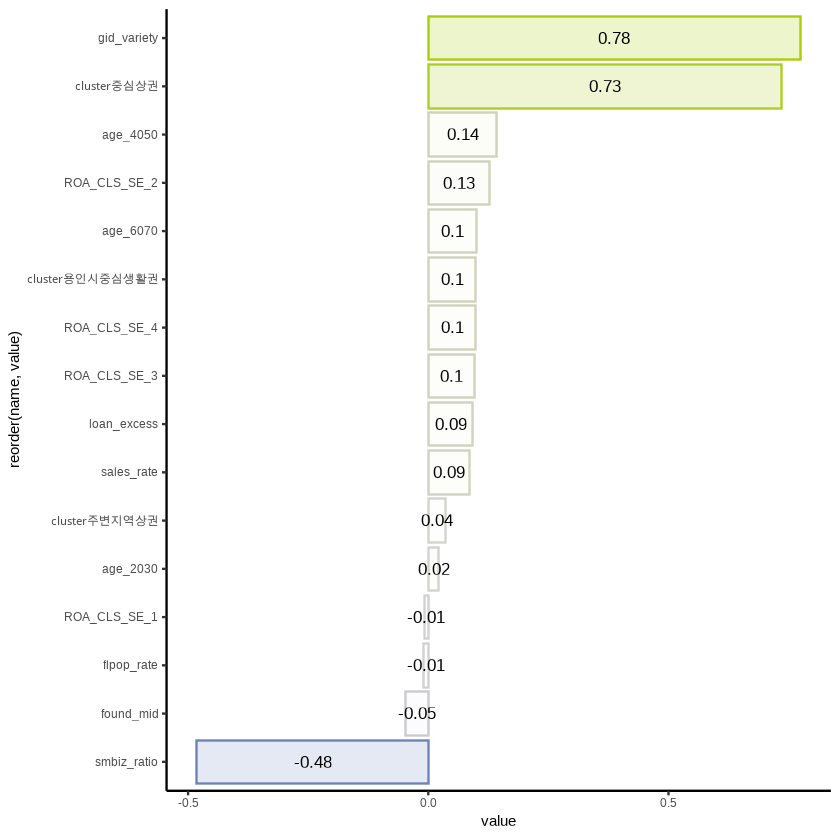

In [58]:
df <- data.frame(name = names(coefficients(lm.fit_slx)),
                 value = coefficients(lm.fit_slx)) %>% 
       spread(name, value) %>% 
       select(-c(starts_with("lag"), starts_with("("))) %>% 
       gather(key = "name", value = "value")

p1 <- df %>% ggplot(aes(x = reorder(name, value), y = value)) + 
    geom_col(aes(fill = value, color = value), alpha = 0.2) + 
    coord_flip() +
    geom_text(aes(label = round(value,2)), size = 4.5, position = position_stack(0.5)) + 
    scale_fill_gradient2(mid = "white",
                         low = "#0057a3", 
                         high = "#a9cd07",
                         midpoint = 0, 
                         limit = c(min(df$value),max(df$value))) +
    scale_color_gradient2(mid = "lightgray",
                          low = "#0057a3",
                          high = "#a9cd07",
                          midpoint = 0, 
                          limit = c(min(df$value),max(df$value))) +
    theme_classic() + theme(legend.position = 'none')

p1

#### 2.3-3 지역(격자) 추출 예시
- 업종 다양성(gid_variety), 4050카드 사용 비율(age_4050)은 높고,
- 유동인구 증가율(flpop_rate), 성숙기 사업체 비율(found_mid)은 낮고
- 지역 클러스터 지표는 "중심상권"인 격자 추출

In [59]:
filtering <- data %>% filter(data$gid_variety > 5 & age_4050 > 49.20 & flpop_rate < -0.00721 & 
                             found_mid < 0.7143 & cluster == '중심상권' ) 
filtering

gid,Y_stable,smbiz_ratio,found_mid,age_2030,age_4050,age_6070,loan_excess,sales_rate,gid_variety,ROA_CLS_SE_1,ROA_CLS_SE_2,ROA_CLS_SE_3,ROA_CLS_SE_4,flpop_rate,cluster
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<fct>
다사62aa19ba,53755,0.7337278,0.6153846,33.51,52.56,4.69,0.8305085,-0.09457639,11,0,0,2,7,-0.02991321,중심상권
다사62aa19bb,82182,0.6363636,0.6417112,33.07,55.98,5.48,0.8985507,-0.09026302,10,0,0,2,3,-0.03388902,중심상권
다사64aa25aa,124329,0.6514523,0.6804979,26.88,51.10,10.08,0.8854167,-0.13255004,9,0,0,4,8,-0.20170770,중심상권
다사66ab21ba,177898,0.6875000,0.6339286,21.98,54.02,17.74,0.9361702,1.97742222,8,0,0,2,1,-0.07683572,중심상권
다사75aa18bb,21337,0.8629032,0.6532258,34.57,50.56,5.04,0.8292683,-0.15982832,8,0,0,0,20,-0.23213456,중심상권


In [18]:
## 지도 시각화를 위한 맵핑(Mapping)

filtering_map <- data_16[which(data_16$gid %in% filtering$gid), ] 
filtering_map@data$id <- rownames(filtering_map@data)
map = fortify(filtering_map, region = "id")
map_merge<- merge(map, filtering_map@data, by = "id")

- 예시 1 : 다사62aa19ba,다사62aa19bb 

In [19]:
## 좌표 계산

map_merge %>% filter(gid == "다사62aa19ba") %>% select(long, lat)
map_merge %>% filter(gid == "다사62aa19bb") %>% select(long, lat)

long,lat
<dbl>,<dbl>
127.0714,37.27364
127.0714,37.27589
127.0742,37.27590
127.0742,37.27365
127.0714,37.27364


long,lat
<dbl>,<dbl>
127.0714,37.27589
127.0714,37.27815
127.0742,37.27816
127.0742,37.27590
127.0714,37.27589


In [20]:
leaflet(map_merge) %>% 
  setView(lng = 127.0714 , lat = 37.27590, zoom = 15.5) %>% 
  addProviderTiles('OpenStreetMap.Mapnik') %>% 
  addRectangles(
    lng1=127.0714, lat1 = 37.27364,
    lng2=127.0742, lat2 = 37.27590,
    fillColor = "#a9cd07", color ='#014700') %>%  
  addRectangles(
    lng1=127.0714, lat1 = 37.27589,
    lng2=127.0742, lat2 = 37.27816,
    fillColor = "#a9cd07", color ='#014700')  

HTML widgets cannot be represented in plain text (need html)

- 기흥구 영덕동 

- 예시 2 : 다사64aa25aa

In [21]:
## 좌표 계산

map_merge %>% filter(gid == "다사64aa25aa") %>% select(long, lat)

long,lat
<dbl>,<dbl>
127.0937,37.32330
127.0937,37.32555
127.0965,37.32556
127.0965,37.32331
127.0937,37.32330


In [22]:
leaflet(map_merge) %>% 
  setView(lng = 127.0951, lat = 37.32443, zoom = 16.5) %>% 
  addProviderTiles('OpenStreetMap.Mapnik') %>% 
  addRectangles(
    lng1=127.0937, lat1=37.32330,
    lng2=127.0965, lat2=37.32556,
    fillColor = "#a9cd07", color ='#014700') #다사64aa25aa

HTML widgets cannot be represented in plain text (need html)

- 기흥구 풍덕천동

- 예시 3 : 다사66ab21ba

In [23]:
## 좌표 계산

map_merge %>% filter(gid == "다사66ab21ba") %>% select(long, lat)

long,lat
<dbl>,<dbl>
127.1192,37.29183
127.1192,37.29409
127.1220,37.29409
127.1220,37.29184
127.1192,37.29183


In [24]:
leaflet(map_merge) %>% 
  setView(lng =127.1206, lat=37.29296, zoom = 16.6) %>% 
  addProviderTiles('OpenStreetMap.Mapnik') %>% 
  addRectangles(
    lng1=127.1192, lat1 = 37.29183,
    lng2=127.1220, lat2 = 37.29409,
    fillColor = "#a9cd07", color ='#014700') 

HTML widgets cannot be represented in plain text (need html)

- 기흥구 언남동